# The random walk process of Ethereum  

There are countless situations where it would be good to know the future price of an asset or a crypto coin. For decades people have been applying everything from statistics, technical analysis and fundamentals to astrology only to find that no method consistently give accurate results across different timescales and markets.  
  
All markets will act irrational at times, which means there will be inefficiences and any systems for price prediction will break down in certain situation. [A Random Walk Down Wallstreet]( https://en.wikipedia.org/wiki/A_Random_Walk_Down_Wall_Street) is a book that popularized the random walk hypthotezis in stock markets.  
  
In this project, we will explore a cryptoasset modelled as a random walk process. A random walk model can be used as a tool in many risk assessment situations around DeFi, and upcoming examples in this series will explore this further.
  
  
  
### Part 1 - load and plot data
We're using TheGraph to load daily Uniswap v2 price data for ETH/USD, and then plot the data for visual inspection.

In [1]:
import requests
import json
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt

In [25]:
# TheGraph GraphQL queries
# Subgraph ID: QmWTrJJ9W8h3JE19FhCzzPYsJ2tgXZCdUqnbyuo64ToTBN
# Subgraph URL: https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2

# Data generated from TheGraph Uniswap v2 public, hosted API at https://thegraph.com/explorer/subgraph/uniswap/uniswap-v2
# Token ID for WETH: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
# Token ID for WBTC: 0x2260fac5e5542a773aa44fbcfedf7c193bc2c599

# Sample GraphQL query:
# Daily price data for WETH in USD. Change the token ID e.g. to WBTC above to test another token. The public, 
# hosted TheGraph APIs are limited to 1000 values in the reply.

query = """query {
    tokenDayDatas(first:1000, where: {token: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}, orderBy: date, orderDirection: desc) {
      date
      priceUSD
    }
}"""

# Call the public hosted TheGraph endpoint
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
r = requests.post(url, json={'query': query})
print(r.status_code)


200


In [26]:
# Transform the string into a json object
json_data = json.loads(r.text)

# Create an empty Numpy array
arr = np.empty((0,2), int)

# Populate the Numpy array, while converting Unix timestamps to datetime objects, and price to float numbers
for l in json_data['data']['tokenDayDatas']:
    arr = np.append(arr, np.array([[datetime.fromtimestamp(l['date']), np.float(l['priceUSD'])]]), axis=0)

Text(0, 0.5, 'usd')

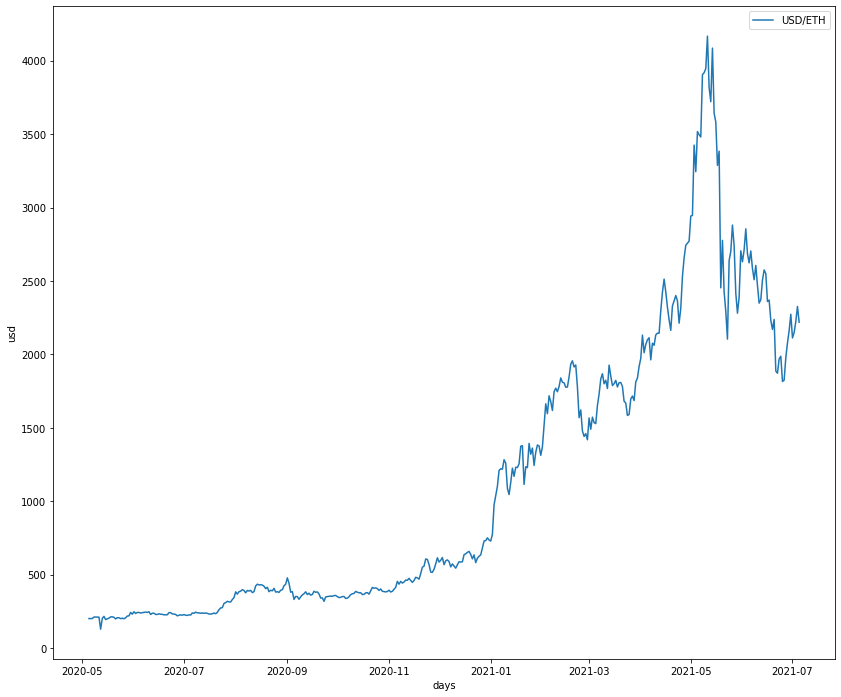

In [27]:
# Plot the data
f, ax = plt.subplots(1,1,figsize=(14,12))
ax.plot((arr[:,0]),arr[:,1], label='USD/ETH' )
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('usd')
#ax.set_yscale('log')

We start by investigating if we can model the random walk of Ethereum in the form:

$X_t = X_{t-1} R_t$

where:

$X_t$: Ethereum value at time t

$R_t = \frac{X_{t+1}}{X_{t}}$: the stochastic process that we want to model.

That means, price price at time t is equal to the price at time t-1 multiplied with a stochastic (random) process.

With a model of of the stochastic process we will investigate two things:  
Is $R_t$ independent of $X_{t-1}$? i.e.: $p(R_t=r | X_{t-1}) = p(R_t=r)$

Is $R_t$ independent of t?

In [28]:
#R_t
d_data = arr[1:,1]/arr[:-1,1]

### Check if $R_t$ is independent of $X_{t-1}$  
  
By sorting the d_value by the order of its previous value we can investigate if the deviaion of the d_value is dependent by the value. We calculate the moving std with a window of 100 to see if the standard deviation change as a function of the previous value.

Text(0, 0.5, 'Relative change')

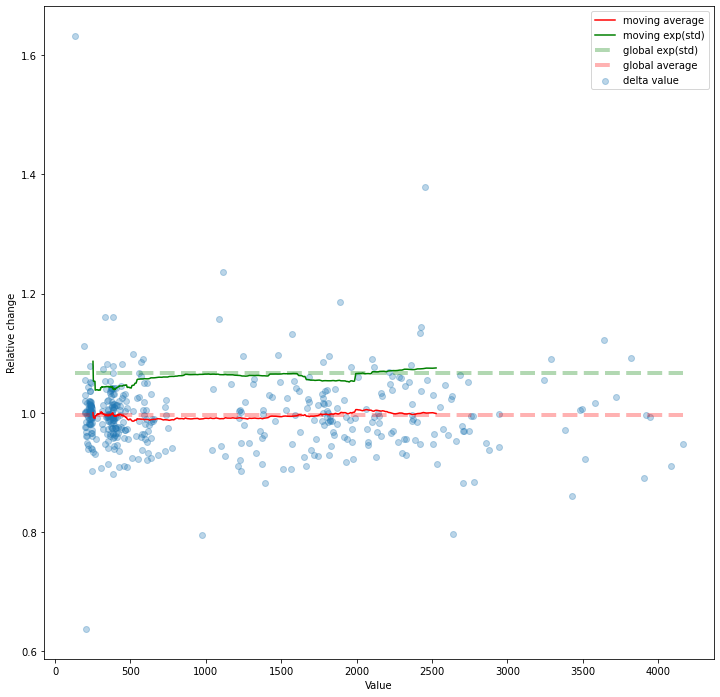

In [42]:
f, ax = plt.subplots(1,1,figsize=(12,12))
ind = np.argsort(arr[:-1,1])

# Calculate the standard deviation and mean 
moving_std = [np.exp(np.std(d_data[ind][i:i+100])) for i in range(len(d_data)-100)]
moving_mean = [np.mean(d_data[ind][i:i+100]) for i in range(len(d_data)-100)]

value_size = [np.mean(arr[ind,1][i:i+100]) for i in range(len(d_data)-100)]

# Plot settings
ax.scatter(arr[ind,1],d_data[ind], label='delta value',alpha=0.3)
ax.plot(value_size, moving_mean, label="moving average",c='red')

ax.plot(value_size, moving_std, label="moving exp(std)",c='green')
std = np.exp(np.std(d_data))
ax.plot([arr[ind,1][0], arr[ind,1][-1]], [std, std], label="global exp(std)",c='green', ls='--', alpha = 0.3, lw=4)
mean = np.mean(d_data)
ax.plot([arr[ind,1][0], arr[ind,1][-1]], [mean, mean], label="global average",c='red', ls='--', alpha = 0.3, lw=4)

ax.legend()
ax.set_xlabel("Value")
ax.set_ylabel("Relative change")

On the y-axis is the daily relative change in price, and the x-axis is the value expressed in USD. Most daily variation is in the +/- 15% range, but there are outliers with more than 30% drop and a 60% increase in just one day.

When looking at the green and red solid lines (the 100 day moving average for daily change and its standard deviation) there is no clear trend. If there was a trend, we should see the line go up or down as the price increased. The dashed lines are the global averages for the daily mean change and standard deviation.

### Conclusion
The mean and the standard deviation of the d_value does not seem to depend of the magnitude of its previous value so it seems reasonable to assume that volatility is relative to the value.

### Assumtion
Now we can assume that the random walk process of the Ethereum price can be written in the form:

$X_t = X_{t-1} e^{\mu+\sigma R}$

where R is some normalized stochastic process (white noise) and $\mu$ is the drift and $\sigma$ some volatility factor.

TypeError: float() argument must be a string or a number, not 'datetime.timedelta'

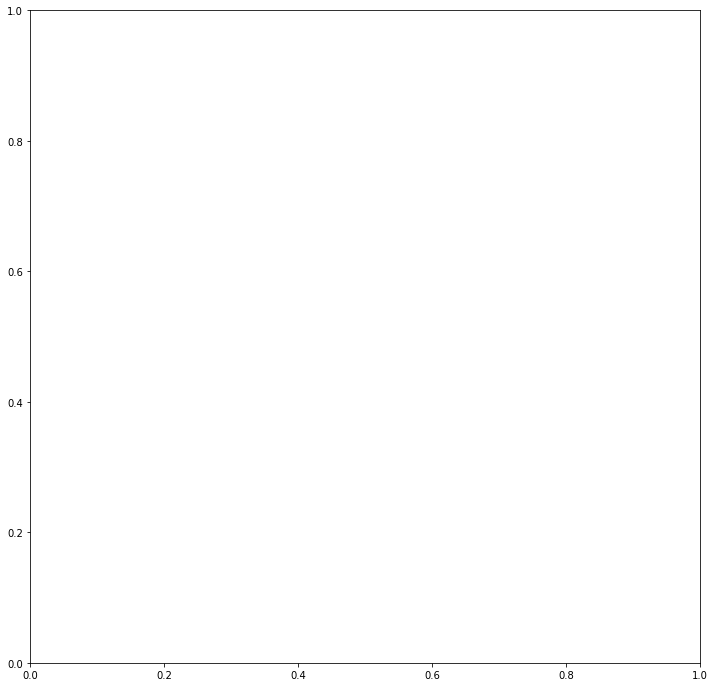

In [43]:
f, ax = plt.subplots(1,1,figsize=(12,12))
moving_std = [np.exp(np.std(d_data[i:i+100])) for i in range(len(d_data)-100)]
moving_mean = [np.mean(d_data[i:i+100]) for i in range(len(d_data)-100)]

time = [np.mean(arr[1:,0][i:i+100]-arr[-1,0])/(24*3600*1000) for i in range(len(d_data)-100)]

ax.scatter((arr[1:,0]-arr[-1,0])/(24*3600*1000), d_data, label='delta value',alpha=0.3)
ax.plot(time, moving_mean, label="moving average",c='red')

ax.plot(time, moving_std, label="moving exp(std)",c='green')
std = np.exp(np.std(d_data))
ax.plot(np.array([arr[0,0]-arr[-1,0], 0])/(24*3600*1000), [std, std], label="global exp(std)",c='green', ls='--', alpha = 0.3, lw=4)
mean = np.mean(d_data)
ax.plot(np.array([arr[0,0]-arr[-1,0], 0])/(24*3600*1000), [mean, mean], label="global average",c='red', ls='--', alpha = 0.3, lw=4)

ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Relative change")

Intro to binning

In [32]:

my_bins = np.linspace(0.5,1.5,100)

prob_,bins = np.histogram(d_data,my_bins,density=True)
prob = prob_*np.diff(bins)
values = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)])

Text(0.5, 1.0, 'sampled distribution')

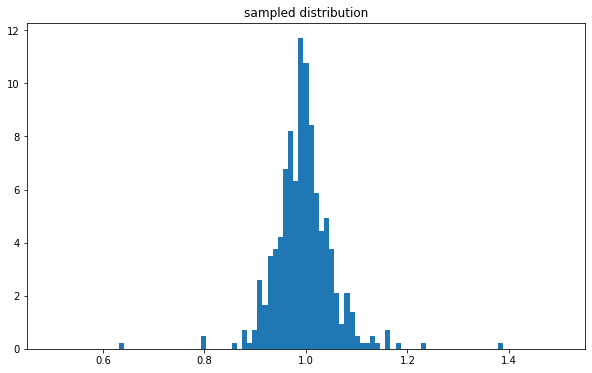

In [39]:
f, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(d_data,my_bins,density=True)
ax.set_title("sampled distribution")

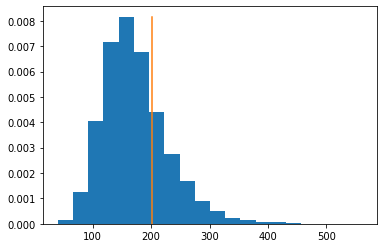

In [46]:
y_bins = np.linspace(0,2,10)

future = 30
proc = lambda: np.prod(np.random.choice(values, p=prob,size=future))
d =arr[-1,1] * np.array([proc() for _ in range(10000)])
dis1,_,_=plt.hist(d,20,density=True)
peak = np.max(dis1)
plt.plot([arr[-1,1], arr[-1,1]], [peak, 0])